## Sampling different looking frames from a video

Following a kmeans approach suggested in DeepLabCut.

In [1]:
#from https://github.com/DeepLabCut/DeepLabCut/blob/6eefd0ccbc320daa76fb07c767209a37cc6fe40e/deeplabcut/utils/frameselectiontools.py#L1

In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.util import img_as_ubyte
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Single video

In [31]:
vid = "vid000.mp4"
path = "/usr/users/agecker/datasets/ExplorationRoomZurna/hum/hum_2021-09-21_M1-2_cam19415032/"

cap = cv2.VideoCapture(path + vid)
numframes2pick = 5
step = 50
resizewidth=30
batchsize=100
max_iter=50
color=False
Index = None
allocated = False

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
nx = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
ny = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
ratio = resizewidth * 1.0 / nx


if Index is None:
    Index = np.arange(0, total_frames, step)
else:
    Index = np.array(Index)
    Index = Index[(Index >= 0) * (Index < total_frames)]  # crop to range!
    
selected_frames = len(Index)

In [32]:
selected_frames

420

In [34]:
for counter, index in tqdm(enumerate(Index)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    if frame is not None:
        image = img_as_ubyte(
            cv2.resize(
                frame,
                None,
                fx=ratio,
                fy=ratio,
                interpolation=cv2.INTER_NEAREST))  
        if not allocated:  
            DATA = np.empty(
                (selected_frames, np.shape(image)[0], np.shape(image)[1] * 3)
            )
            allocated = True
        DATA[counter, :, :] = np.hstack(
            [image[:, :, 0], image[:, :, 1], image[:, :, 2]]
        )

420it [00:04, 101.79it/s]


In [35]:
DATA.shape # (21000, 22, 90) 21000 images, 22 x 30 proportion after downsampling + 3 channels

(420, 22, 90)

In [86]:
numframes2pick = 16 # ideally a square number (e.g. 9, 16, 25)
data = DATA - DATA.mean(axis=0)
data = data.reshape(nframes, -1)  # stacking
print(data.shape)
kmeans = MiniBatchKMeans(
    n_clusters=numframes2pick, tol=1e-3, batch_size=batchsize, max_iter=max_iter
)
kmeans.fit(data)

frames2pick = []
for clusterid in range(numframes2pick):  # pick one frame per cluster
    clusterids = np.where(clusterid == kmeans.labels_)[0]

    numimagesofcluster = len(clusterids)
    if numimagesofcluster > 0:
        frames2pick.append(
            Index[clusterids[np.random.randint(numimagesofcluster)]]
        )
# cap.release() >> still used in frame_extraction!
print(list(np.array(frames2pick)))

(420, 1980)
[7350, 20850, 3450, 3900, 8600, 5950, 9650, 20050, 9250, 19250, 6300, 2050, 3750, 8000, 8750, 19450]


In [87]:
#pca = PCA(2)
#df = pca.fit_transform(data)

tsne = TSNE(2)
df = tsne.fit_transform(data)

label = kmeans.fit_predict(data)
u_labels = np.unique(label)
 

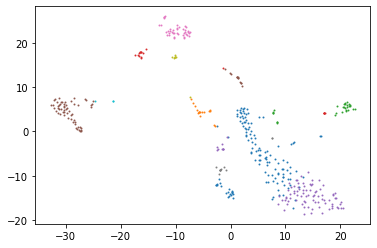

In [88]:
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i, s = 1, alpha = 0.9)
plt.show()

In [89]:
unique, counts = np.unique(label, return_counts=True)

df = pd.DataFrame({"counts": counts, "unique": unique})
df.sort_values("counts", ascending = False).head()

,counts,unique
0,108,0
14,81,14
15,58,15
6,41,6
10,24,10


#### Show one cluster

images in this cluster: 13


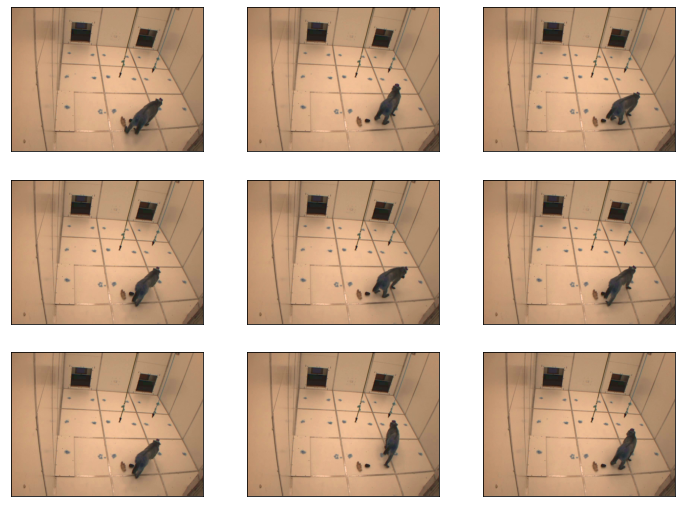

In [95]:
how_many = 3 # will be how_many x how_many ordered in a grid
cluster = 5

ids = np.where(label == cluster)[0]
print("images in this cluster:", len(ids))
frames = Index[ids[np.random.randint(0, len(ids), how_many * how_many)]]

fig, axs = plt.subplots(how_many, how_many, figsize = (12,9))

for i, index in enumerate(list(np.array(frames))):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    axs[i//how_many, i%how_many].imshow(frame)
    axs[i//how_many, i%how_many].get_xaxis().set_visible(False)
    axs[i//how_many, i%how_many].get_yaxis().set_visible(False)

#### Show one representative from each cluster

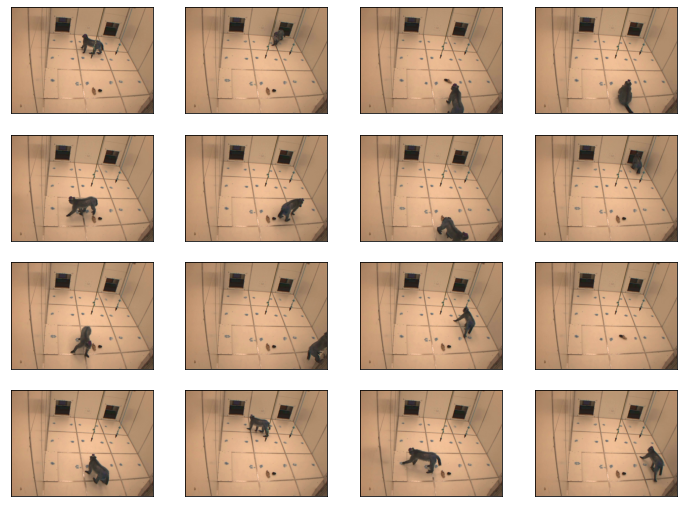

In [97]:
how_many = int(np.sqrt(numframes2pick)) 
fig, axs = plt.subplots(how_many, how_many, figsize = (12,9))

for i, index in enumerate(list(np.array(frames2pick))):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    success, frame = cap.read()
    axs[i//how_many, i%how_many].imshow(frame)
    axs[i//how_many, i%how_many].get_xaxis().set_visible(False)
    axs[i//how_many, i%how_many].get_yaxis().set_visible(False)

## Multiple videos

In [ ]:
# vids = ["Train"+str(i)+"_far" for i in range(1,4)] + ["Train"+str(i)+"_close" for i in range(4,11)]
from pathlib import Path

#where to save the output images
output_path = Path('/media/hdd2/matthias/datasets/lemur_box/validation/raw_frames/')

#where to find the videos
input_path = Path('/media/hdd2/matthias/sfb1528_storage/Z01/PlaygroundSessions4ActionClassification/')
video_list = [x for x in input_path.glob('*.mp4')]


for _, vid in tqdm(enumerate(video_list)):
    # print(f"start on {vid}")

    cap = cv2.VideoCapture(str(vid))
    numframes2pick = 30
    step = 35 # 2 frames per second (70fps videos)
    resizewidth=30
    batchsize=100
    max_iter=50
    color=False
    Index = None
    allocated = False

    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(f"gonna select from {nframes//step} frames")
    nx = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    ny = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    ratio = resizewidth * 1.0 / nx


    if Index is None:
        Index = np.arange(0, nframes, step)
    else:
        Index = np.array(Index)
        Index = Index[(Index >= 0) * (Index < nframes)]  # crop to range!

    nframesUsed = len(Index)

    # print("gonna read those frames")
    for counter, index in tqdm(enumerate(Index)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        success, frame = cap.read()
        if frame is not None:
            image = img_as_ubyte(
            cv2.resize(
                frame,
                None,
                fx=ratio,
                fy=ratio,
                interpolation=cv2.INTER_NEAREST))  # color trafo not necessary; lack thereof improves speed.
            if not allocated:  #'DATA' not in locals(): #allocate memory in first pass
                DATA = np.empty(
                    (nframesUsed, np.shape(image)[0], np.shape(image)[1] * 3)
                )
                allocated = True
            DATA[counter, :, :] = np.hstack(
                [image[:, :, 0], image[:, :, 1], image[:, :, 2]]
            )


    # print("gonna get those clusters")
    data = DATA - DATA.mean(axis=0)
    data = data.reshape(nframesUsed, -1)  # stacking
    # print(data.shape)
    kmeans = MiniBatchKMeans(
        n_clusters=numframes2pick, tol=1e-3, batch_size=batchsize, max_iter=max_iter
    )
    kmeans.fit(data)

    frames2pick = []
    # print("gonna pick those frames")
    for clusterid in range(numframes2pick):  # pick one frame per cluster
        clusterids = np.where(clusterid == kmeans.labels_)[0]
        print(clusterids)
        numimagesofcluster = len(clusterids)
        if numimagesofcluster > 0:
            frames2pick.append(
                Index[clusterids[np.random.randint(numimagesofcluster)]]
                # clusterids[np.random.randint(numimagesofcluster)]
            )
    # cap.release() >> still used in frame_extraction!
    # print(list(np.array(frames2pick)))
    
    # print("gonna save those frames")
    for i, index in enumerate(list(np.array(frames2pick))):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        success, frame = cap.read()
        cv2.imwrite((str(output_path / vid.stem) + f"_{index}.png"), frame)#.with_suffix(".png"))
    # print("="*250)